In [1]:
from src import tpu_setup

In [5]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [6]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.01
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [7]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms


class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)


def train_mnist():
  torch.manual_seed(1)
  
  if not xm.is_master_ordinal():
    # Barrier: Wait until master is done downloading
    xm.rendezvous('download_only_once')

  # Get and shard dataset into dataloaders
  norm = transforms.Normalize((0.1307,), (0.3081,))
  train_dataset = datasets.MNIST(
      FLAGS['datadir'],
      train=True,
      download=True,
      transform=transforms.Compose(
          [transforms.ToTensor(), norm]))
  test_dataset = datasets.MNIST(
      FLAGS['datadir'],
      train=False,
      download=True,
      transform=transforms.Compose(
          [transforms.ToTensor(), norm]))
  
  if xm.is_master_ordinal():
    # Barrier: Master done downloading, other workers can proceed
    xm.rendezvous('download_only_once')

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = MNIST().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [8]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

 GlobalRate=186.27 Time=Wed May 13 22:36:36 2020
[xla:2](0) Loss=0.17236 Rate=180.31 GlobalRate=180.30 Time=Wed May 13 22:36:36 2020
[xla:6](20) Loss=0.06498 Rate=2428.21 GlobalRate=1969.62 Time=Wed May 13 22:36:37 2020
[xla:5](20) Loss=0.15600 Rate=2433.74 GlobalRate=2008.61 Time=Wed May 13 22:36:37 2020
[xla:0](20) Loss=0.13816 Rate=2410.88 GlobalRate=1970.47 Time=Wed May 13 22:36:37 2020
[xla:7](20) Loss=0.14673 Rate=2374.59 GlobalRate=1970.62 Time=Wed May 13 22:36:37 2020
[xla:3](20) Loss=0.15537 Rate=2395.19 GlobalRate=1977.63 Time=Wed May 13 22:36:37 2020
[xla:1](20) Loss=0.08047 Rate=2194.95 GlobalRate=1986.06 Time=Wed May 13 22:36:37 2020
[xla:4](20) Loss=0.13028 Rate=2418.67 GlobalRate=2024.38 Time=Wed May 13 22:36:37 2020
[xla:2](20) Loss=0.15555 Rate=2421.44 GlobalRate=1971.08 Time=Wed May 13 22:36:37 2020
[xla:5](40) Loss=0.08765 Rate=3237.39 GlobalRate=2602.24 Time=Wed May 13 22:36:38 2020
[xla:4](40) Loss=0.04056 Rate=3245.25 GlobalRate=2621.18 Time=Wed May 13 22:36:38 20

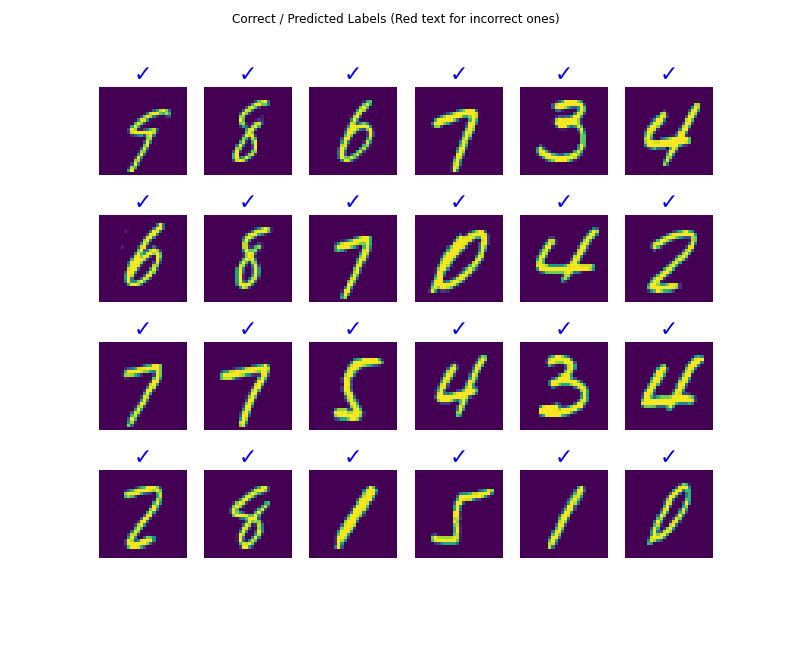

In [11]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [1]:
import os

In [1]:
inp=['how', 'did', 'the', 'schoolboys', 'stop', 'maclean', '?']
opt=['what', 'was', 'the', 'name', 'of', 'the', 'first', 'synthetic', 'dye', '?']


In [2]:
from nltk.translate.bleu_score import sentence_bleu


In [8]:
sentence_bleu([inp],opt)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.668740304976422

In [30]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']

print('Cumulative 4-gram: %f' % corpus_bleu([reference], [candidate]))

Cumulative 4-gram: 0.707107
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [31]:
from torchtext.data.metrics import bleu_score

In [33]:
bleu_score([candidate], [reference])

0.0

In [51]:
candidate_corpus = ['this', 'is', 'the', 'test']

In [52]:
references_corpus = ['this', 'is', 'a', 'test']

In [53]:
bleu_score(candidate_corpus, references_corpus)

0.0

In [54]:
from collections import Counter
import math
import numpy as np
import subprocess


def bleu_stats(hypothesis, reference):
    """Compute statistics for BLEU."""
    stats = []
    stats.append(len(hypothesis))
    stats.append(len(reference))
    for n in range(1, 5):
        s_ngrams = Counter(
            [tuple(hypothesis[i:i + n]) for i in range(len(hypothesis) + 1 - n)]
        )
        r_ngrams = Counter(
            [tuple(reference[i:i + n]) for i in range(len(reference) + 1 - n)]
        )
        stats.append(max([sum((s_ngrams & r_ngrams).values()), 0]))
        stats.append(max([len(hypothesis) + 1 - n, 0]))
    return stats


def bleu(stats):
    """Compute BLEU given n-gram statistics."""
    if len(list(filter(lambda x: x == 0, stats))) > 0:
        return 0
    (c, r) = stats[:2]
    log_bleu_prec = sum(
        [math.log(float(x) / y) for x, y in zip(stats[2::2], stats[3::2])]
    ) / 4.
    return math.exp(min([0, 1 - float(r) / c]) + log_bleu_prec)


def get_bleu(hypotheses, reference):
    """Get validation BLEU score for dev set."""
    stats = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for hyp, ref in zip(hypotheses, reference):
        stats += np.array(bleu_stats(hyp, ref))
    return 100 * bleu(stats)

In [55]:
get_bleu(hypotheses=candidate_corpus,reference=references_corpus)

83.17648078335372

In [2]:
import pandas as pd
df=pd.read_csv("/root/Question_generation/src/saved_models/transformer/5/test_df_metrics.csv")

In [3]:
df.head()

,Unnamed: 0,input,output,pred,bleu
0,0,there have been two major trends in the changi...,how many big trends are involved in how much t...,how many dogs have been in the last part of ?,16.694477
1,1,doug lombardi vp of marketing for valve has si...,who is valve s vp of marketing who says they w...,what has been criticized for the kinsey scale ?,0.000000
2,2,weather does not occur in the higher stratosph...,where on neptune does weather not occur ?,what is the maximum rate of the st . barts ?,0.000000
3,3,from 1721 this was the whig politician robert ...,what party did walpole belong to ?,who was the last republican senator ?,0.000000
4,4,"the winning amateur director film, the cyborg ...",what prize was awarded to the winning amateur ...,how many oscar did the movie classics ?,0.000000


In [6]:
df.mean()["bleu"]

8.457652803648449

In [3]:
from src.utils import save_to_artifact 

In [4]:
save_to_artifact("transformer",8)

In [2]:
from src.test_metrics.pycocoevalcap.bleu import bleu

In [3]:
bleu_scorer=bleu.Bleu()


In [29]:
bleu_score=bleu_scorer.compute_score({1:["Hello who are you"],2:["whats up"]},{1:["Hello who are you"],2:["whats up"]})
print(bleu_score[0])

{'testlen': 6, 'reflen': 6, 'guess': [6, 4, 2, 1], 'correct': [6, 4, 2, 1]}
ratio: 0.9999999998333334
[0.9999999996666668, 0.9999999996250001, 0.999999999527778, 0.9999999993541671]


In [16]:
def to_list(x):
    return [x]
df["output"]=df["output"].apply(to_list)
df["pred"]=df["pred"].apply(to_list)

x=df.to_dict()

gts=x["output"]
res=x["pred"]

bleu_scorer=bleu.Bleu()


bleu_score=bleu_scorer.compute_score(gts,res)
print(f"Bleu1 : {bleu_score[0][0]} \nBleu2 : {bleu_score[0][1]} \nBleu3 : {bleu_score[0][2]} \nBleu4 : {bleu_score[0][3]} \n")

{'testlen': 1210293, 'reflen': 86726, 'guess': [1210293, 1198396, 1186499, 1174602], 'correct': [927, 0, 0, 0]}
ratio: 13.955365173073657
Bleu1 : 0.0007659302334228152 
Bleu2 : 7.99455750879407e-13 
Bleu3 : 8.13655370130694e-16 
Bleu4 : 2.602301951174219e-17 



In [15]:
import pandas as pd
df=pd.read_csv("./src/saved_models/seq2seq/7/test_df.csv")

In [9]:
gts.keys()

NameError: name 'gts' is not defined

In [13]:
x.keys()

dict_keys(['Unnamed: 0', 'input', 'output', 'pred', 'bleu'])

In [23]:
print(bleu_score[0])

[0.0007659302334228152, 7.99455750879407e-13, 8.13655370130694e-16, 2.602301951174219e-17]


In [34]:

import subprocess
import pandas as pd

def get_jobs():
    def has_data(job_id):
        process = subprocess.Popen(['gradient','jobs','artifacts','list','--id', job_id],
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        return not("No data found" in stdout.decode("utf-8").split('\r')[-2])

    process = subprocess.Popen(['gradient','jobs','list','--project', 'Job Builder'],
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    x=stdout.decode("utf-8") 
    x=x.split("\n")
    jobs=x[3:-1]
    jobs=[[j.strip() for j in  i.split("|")][1:-1] for i in jobs]
    jobs=pd.DataFrame(jobs,columns=["id","Name","from","location","device","time"])
    jobs["has_data"]=jobs["id"].apply(has_data)
    return jobs

In [79]:
def download_jobs(jobs,dir):
    def download_job(job_id,download_dir):
        process = subprocess.Popen(['gradient','jobs','artifacts','download','--id', job_id ,"--destinationDir" ,download_dir],
                            stdout=subprocess.PIPE, 
                            stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
    to_download=jobs[jobs["has_data"]]
    job_list=to_download["id"]
    for job in job_list:
        download_job(job,f"./gradient/{job}")
    print("Jobs Downloaded")
    

,id,Name,from,location,device,time,has_data
0,jpzuxptwrj29g,TRANSFORMER,Job Builder,PS Jobs on GCP,K80,2020-06-20T09:49:47.141Z,False
1,jxxqmmwirf9lr,Transformer - 3 layer,Job Builder,PS Jobs on GCP,P100,2020-06-20T10:05:03.044Z,False
2,jsifntw9hsl4uo,Clone - jnnddwaf0bwfk,Job Builder,PS Jobs on GCP,K80,2020-06-22T09:03:16.759Z,False
3,j4nqncmkg7hnh,Clone - jsifntw9hsl4uo,Job Builder,PS Jobs on GCP,P100,2020-06-22T09:10:54.134Z,False
4,jsg3uo6ur73f09,Clone - jowi8r8v92lp4,Job Builder,PS Jobs on GCP,GV100,2020-06-22T09:20:28.232Z,False
5,jsdzhy8zewcqhk,Clone - jsg3uo6ur73f09,Job Builder,PS Jobs on GCP,K80,2020-06-22T09:43:44.862Z,False
6,jszg94gnb29n6m,Clone - jjsb2omk2rr14,Job Builder,PS Jobs on GCP,P100,2020-06-22T17:07:25.805Z,False
7,jskz4g0bzeovf8,Clone - jsaeydpkyvn6vr,Job Builder,PS Jobs,V100,2020-06-22T06:34:48.104Z,False
8,jsr33pg90zqv2u,Clone - jnh9slki2xryj,Job Builder,PS Jobs on GCP,K80,2020-06-01T23:48:57.597Z,False
9,jfs69h6dtl4zn,Clone - jslaud9jfiukso,Job Builder,PS Jobs,P6000,2020-05-27T02:18:20.219Z,False


In [87]:
def download_job(job_id,download_dir):
    process = subprocess.Popen(['gradient','jobs','artifacts','download','--id', job_id ,"--destinationDir" ,download_dir],
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()


In [88]:
download_job("jjsb2omk2rr14","./gradient/jjsb2omk2rr14")

b'\r\r\xe2\xa0\x8b Waiting for data...\r\r\xe2\xa0\x99 Waiting for data...\r\r\xe2\xa0\xb9 Waiting for data...\r\r\xe2\xa0\xb8 Waiting for data...\r\r\xe2\xa0\xbc Waiting for data...\r\r\xe2\xa0\xb4 Waiting for data...\r\r\xe2\xa0\xa6 Waiting for data...\r\r\xe2\xa0\xa7 Waiting for data...\r\r\xe2\xa0\x87 Waiting for data...\r\r\xe2\xa0\x8f Waiting for data...Downloading: seq2seq/2/hp.json\n\r\r\xe2\xa0\x8b Waiting for data...\r\r\xe2\xa0\x99 Waiting for data...\r\r\xe2\xa0\xb9 Waiting for data...\r\r\xe2\xa0\xb8 Waiting for data...Downloading: seq2seq/2/inpLang.p\n\r\r\xe2\xa0\xbc Waiting for data...\r\r\xe2\xa0\xb4 Waiting for data...\r\r\xe2\xa0\xa6 Waiting for data...\r\r\xe2\xa0\xa7 Waiting for data...\r\r\xe2\xa0\x87 Waiting for data...\r\r\xe2\xa0\x8f Waiting for data...\r\r\xe2\xa0\x8b Waiting for data...\r\r\xe2\xa0\x99 Waiting for data...\r\r\xe2\xa0\xb9 Waiting for data...\r\r\xe2\xa0\xb8 Waiting for data...\r\r\xe2\xa0\xbc Waiting for data...\r\r\xe2\xa0\xb4 Waiting for dat

In [60]:
has_data("jspy8nuxc10zdk")

True

In [77]:
jobs[jobs["has_data"]]

,id,Name,from,location,device,time,has_data
18,jspy8nuxc10zdk,Transformer - 3 layer (More Epochs),Job Builder,PS Jobs on GCP,P100,2020-07-07T09:22:16.568Z,True
22,jskxtx7oexy58,Seq2seq,Job Builder,PS Jobs on GCP,P100,2020-07-08T04:08:37.779Z,True
23,jtxhdu53v2po,Transformer - 3 layer,Job Builder,PS Jobs,V100,2020-06-20T10:17:00.086Z,True
29,jkda4s46ulvji,Transformer - 3 layer NMT,Job Builder,PS Jobs,V100,2020-07-07T07:59:42.944Z,True
31,jstuzattsrck0d,Transformer - 3 layer,Job Builder,PS Jobs,V100,2020-07-08T04:09:20.999Z,True
32,jsaeydpkyvn6vr,Seq2seq,Job Builder,PS Jobs,V100,2020-06-20T06:54:04.087Z,True
34,jqcs6nd92em5w,Clone - j60yrh5xb4c4k,Job Builder,PS Jobs,V100,2020-06-20T06:51:57.335Z,True
38,jjsb2omk2rr14,Seq2seq pretrained,Job Builder,PS Jobs,V100,2020-06-22T06:39:49.054Z,True
40,jxwdub0p4px7o,Clone - jyqgjfa5dojrf,Job Builder,PS Jobs,V100,2020-06-20T06:51:57.308Z,True
51,jsquf8ws0h6ho0,Transformer - 5 layer (More Epochs),Job Builder,PS Jobs on GCP,P100,2020-07-07T17:21:20.635Z,True


In [138]:
transient_dir = "./gradient/"
import glob
jobs = glob.glob(f"{transient_dir}*")


In [139]:
jobs

['./gradient/jsaeydpkyvn6vr',
 './gradient/jskxtx7oexy58',
 './gradient/jjsb2omk2rr14',
 './gradient/jtxhdu53v2po',
 './gradient/jqcs6nd92em5w',
 './gradient/jspy8nuxc10zdk',
 './gradient/jsquf8ws0h6ho0',
 './gradient/jxwdub0p4px7o',
 './gradient/jstuzattsrck0d',
 './gradient/jkda4s46ulvji']

In [91]:
from src.utils import get_max_version

In [93]:
get_max_version("attn_seq2seq")

[0, 2, 1]

In [144]:
def copy_to_location(transient_dir):
    jobs = glob.glob(f"{transient_dir}*")
    for job_dir in jobs:
        copy_to_saved(job_dir)
    
def copy_to_saved(job_dir):
    try:
        job_path = glob.glob(f"{job_dir}/*/")[0]
        model_type = job_path.split("/")[-2]
        print(model_type)
        _ver = get_max_version(model_type)
        version = max(_ver)+1 if _ver!=[] else 0
        model_path = f"./src/saved_models/{model_type}/{str(version)}"
        os.makedirs(model_path)
        print(model_path)
        data_files = glob.glob(job_dir+f"/{model_type}/*/*")
        for file_name in data_files:
            shutil.copy(file_name,'%s/%s' % (model_path, file_name.split('/')[-1]))
    except:
        print(f"Failed to load {job_dir}")


In [145]:
copy_to_saved("./gradient/jsaeydpkyvn6vr")

seq2seq
./src/saved_models/seq2seq/0
